# Exercício (a) — Parâmetros, resultados e arquitetura da PINN

## Parâmetros de treinamento

* **Pontos de colocação:**
  – Domínio: **500**
  – Contorno: **50**
  – Teste/avaliação: **200**
* **Função de ativação:** `tanh`
* **Otimizador:** **L-BFGS-B** (quase-Newton).

  > Observação: o pré-treino com **Adam** (`lr = 1e-3`) está comentado e **não foi usado** nesta execução.
* **Épocas / iterações:** L-BFGS-B **não usa épocas** no sentido clássico; o ajuste ocorreu **até convergência** (parâmetros padrão do DeepXDE, no caso sempre rodou 15mil épocas).
* **Taxa de aprendizagem:** **não se aplica** ao L-BFGS-B; (para Adam, seria 0,001, mas foi desativado).

## Estrutura da rede (FNN)

* Camadas: **1–30–30–30–1**
  – **Entrada:** 1 nó ($x$)
  – **Ocultas:** 3 camadas com **30 neurônios** cada
  – **Saída:** 1 nó ($w(x)$)
* Inicialização: **Glorot uniform**
* Totalizando parâmetros: **1.951**

## Resultados: deflexão e ângulo máximos (em $x=L$)

* **Solução analítica**
  – Deflexão $w(L)$: **-10.533246 mm**
  – Ângulo $\theta(L)=w'(L)$: **−0,005267 rad** ≈ **−0,301755°**
* **Solução PINN**
  – Deflexão $w(L)$: **-10.577682 mm**
  – Ângulo $\theta(L)$: **-0.005312 rad** ≈ **-0.304377°**
* **Erro relativo**  
  – Deflexão: **0.42%**  
  – Ângulo: **0.87%**

**Nessa solução:** a PINN contém três camadas ocultas (30 neurônios, `tanh`) e otimização via L-BFGS-B reproduziu muito bem a solução analítica do problema de viga engastada com carga concentrada na ponta, apresentando erros inferiores a 1% tanto na deflexão quanto no ângulo na extremidade livre.


Compiling model...
'compile' took 0.000290 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [9.31e-03, 0.00e+00, 2.37e-03, 6.23e-04, 1.08e-04]    [1.02e-02, 0.00e+00, 2.37e-03, 6.23e-04, 1.08e-04]    []  
1000      [2.19e-07, 2.41e-12, 1.44e-13, 7.65e-10, 1.38e-08]    [2.07e-07, 2.41e-12, 1.44e-13, 7.65e-10, 1.38e-08]    []  
2000      [1.69e-07, 1.28e-12, 1.53e-12, 6.73e-11, 9.83e-09]    [1.57e-07, 1.28e-12, 1.53e-12, 6.73e-11, 9.83e-09]    []  
3000      [1.37e-07, 7.27e-13, 4.57e-12, 1.16e-11, 7.34e-09]    [1.26e-07, 7.27e-13, 4.57e-12, 1.16e-11, 7.34e-09]    []  
4000      [1.14e-07, 4.50e-13, 7.00e-12, 1.04e-10, 5.68e-09]    [1.03e-07, 4.50e-13, 7.00e-12, 1.04e-10, 5.68e-09]    []  
5000      [9.57e-08, 2.95e-13, 8.88e-12, 1.95e-10, 4.52e-09]    [8.66e-08, 2.95e-13, 8.88e-12, 1.95e-10, 4.52e-09]    []  
6000      [8.13e-08, 2.03e-13, 9.11e-12, 2.52e-10, 3.67e-09]    [7.

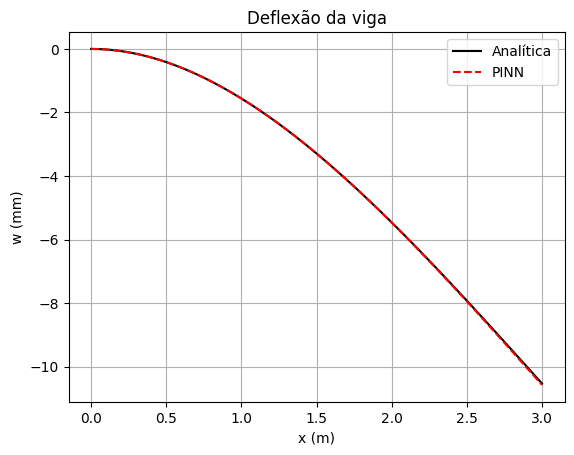

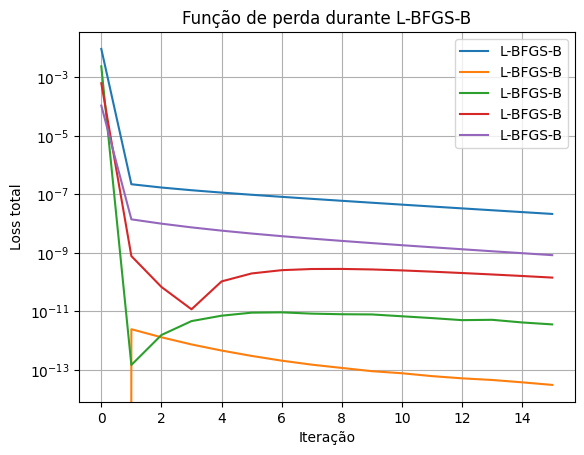

Solução analítica:
  Deflexão máxima w(L) = -10.533246 mm
  Ângulo máximo θ(L)   = -0.005267 rad ≈ -0.301755 graus
Solução PINN:
  Deflexão máxima w(L) = -10.577682 mm
  Ângulo máximo θ(L)   = -0.005312 rad ≈ -0.304377 graus

Erro relativo:
  Deflexão: 0.42 %
  Ângulo:   0.87 %


In [2]:
import deepxde as dde
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---------- Parâmetros do problema ----------
L = 3.0                               # Comprimento da viga [m]
E = 2.10e11                           # Módulo de Young [Pa]
I = 6.51e-5                           # Momento de inércia [m^4]
p = 1.6e4                             # Carga concentrada [N]

# ---------- Equação diferencial: EI w''''(x) = 0 ----------
def pde(x, y):
    d2y = dde.grad.hessian(y, x, i=0, j=0)           # w''
    d4y = dde.grad.hessian(d2y, x, i=0, j=0)         # w''''
    return d4y

# ---------- Geometria ----------
geom = dde.geometry.Interval(0.0, L)

# ---------- Condições de contorno ----------
def on_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0)

def on_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

# w(0) = 0
bc_w0 = dde.DirichletBC(geom, lambda x: 0.0, on_left)

# w'(0) = 0
bc_theta0 = dde.OperatorBC(
    geom,
    lambda x, y, dy: dde.grad.jacobian(y, x, i=0, j=0),
    on_left,
)

# w''(L) = 0
bc_momentL = dde.OperatorBC(
    geom,
    lambda x, y, dy: dde.grad.hessian(y, x, i=0, j=0),
    on_right,
)

# w'''(L) = p/(EI)
def shear_condition(x, y, dy):
    d2y = dde.grad.hessian(y, x, i=0, j=0)
    d3y = dde.grad.jacobian(d2y, x, i=0, j=0)
    return d3y - torch.tensor(p / (E * I), dtype=torch.float32)

bc_shearL = dde.OperatorBC(geom, shear_condition, on_right)

bcs = [bc_w0, bc_theta0, bc_momentL, bc_shearL]

# ---------- Dados ----------
data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=500,
    num_boundary=50,
    num_test=200,
)

# ---------- Rede neural ----------
layer_size = [1] + [30] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# ---------- Modelo ----------
model = dde.Model(data, net)
#model.compile("adam", lr=0.001)

#N_iter = 10
#step = 5000
#losshistory, train_state = model.train(iterations=N_iter, display_every=step)

# ---------- (Opcional) Refinamento com L-BFGS-B ----------
model.compile("L-BFGS-B")
losshistory2, train_state2 = model.train()

# ---------- Pós-processamento ----------
x = np.linspace(0, L, 200).reshape(-1, 1)
w_pred = model.predict(x)

# Solução analítica
w_exact = -p * x**2 * (3*L - x) / (6 * E * I)

# ---------- Gráfico comparativo ----------
plt.figure()
plt.plot(x, w_exact * 1000, "k-", label="Analítica")
plt.plot(x, w_pred * 1000, "r--", label="PINN")
plt.xlabel("x (m)")
plt.ylabel("w (mm)")
plt.title("Deflexão da viga")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Gráfico da loss  ADAM----------
# loss_total = np.array(losshistory.loss_train)
# plt.figure()
# plt.semilogy(loss_total)
# plt.xlabel("Época")
# plt.ylabel("Loss total")
# plt.title("Evolução da função de perda (Adam)")
# plt.grid(True, which="both")
# plt.show()

# Perdas ao longo do L-BFGS-B

loss_lbf = np.array(losshistory2.loss_train)
plt.figure()
plt.semilogy(loss_lbf, label="L-BFGS-B")
plt.xlabel("Iteração")
plt.ylabel("Loss total")
plt.title("Função de perda durante L-BFGS-B")
plt.grid(True, which="both")
plt.legend()
plt.show()


# -------- Solução analítica (x = L) --------
w_exact_L = -p * L**3 / (3 * E * I)
theta_exact_L = -p * L**2 / (2 * E * I)

print(f"Solução analítica:")
print(f"  Deflexão máxima w(L) = {w_exact_L*1000:.6f} mm")
print(f"  Ângulo máximo θ(L)   = {theta_exact_L:.6f} rad ≈ {np.degrees(theta_exact_L):.6f} graus")

# -------- PINN: deflexão e ângulo em x = L --------
x_L = torch.tensor([[L]], dtype=torch.float32, requires_grad=True)

# Previsão da rede (PyTorch)
w_tensor = model.net(x_L)                      # w(L)
dw_dx = torch.autograd.grad(
    w_tensor, x_L,
    grad_outputs=torch.ones_like(w_tensor),
    create_graph=True
)[0]                                           # w'(L)

w_pinn_L = w_tensor.item()
theta_pinn_L = dw_dx.item()

print(f"Solução PINN:")
print(f"  Deflexão máxima w(L) = {w_pinn_L*1000:.6f} mm")
print(f"  Ângulo máximo θ(L)   = {theta_pinn_L:.6f} rad ≈ {np.degrees(theta_pinn_L):.6f} graus")

# -------- Erros relativos --------
erro_w = 100 * (abs(w_pinn_L - w_exact_L) / abs(w_exact_L))
erro_theta = 100* (abs(theta_pinn_L - theta_exact_L) / abs(theta_exact_L))

print(f"\nErro relativo:")
print(f"  Deflexão: {erro_w:.2f} %")
print(f"  Ângulo:   {erro_theta:.2f} %")

